# Method1 SVD+Huffman

### Code

#### Import the EDF file
Installation: https://mne.tools/dev/install/mne_python.html

Function description: https://mne.tools/dev/generated/mne.io.read_raw_edf.html

In [2]:
import mne
file = "/Users/lubaiying/Desktop/big_ideas_lab/DBDP_Compression_Toolbox/Baiying/ECG.EDF"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

Extracting EDF parameters from /Users/lubaiying/Desktop/big_ideas_lab/DBDP_Compression_Toolbox/Baiying/ECG.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
info

<Info | 7 non-empty values
 bads: []
 ch_names: ECG, Marker, HRV
 chs: 3 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2019-07-23 12:16:57 UTC
 nchan: 3
 projs: []
 sfreq: 1000.0 Hz
>

From the above stucture, we can use "raw_data[0]" to extract the ECG signal we needed

In [119]:
raw_data[0].size

3270000

In [118]:
np.savetxt('raw.txt',raw_data[0])  #Save it as a txt file

#### #Convert the edf file into csv and reload the csv file

If we just use raw_data[0], just as the we mentioned above, this step will not be needed anymore

In [4]:
import numpy as np
header = ','.join(data.ch_names)
np.savetxt('ECG.csv', data.get_data().T, delimiter=',', header=header)

In [5]:
import pandas as pd
ecg = pd.read_csv('ECG.csv')

In [6]:
ecg

,# ECG,Marker,HRV
0,0.032767,0.0,0.0
1,0.032767,0.0,0.0
2,0.032767,0.0,0.0
3,0.032767,0.0,0.0
4,0.032767,0.0,0.0
...,...,...,...
3269995,0.002334,0.0,0.0
3269996,0.002037,0.0,0.0
3269997,0.001726,0.0,0.0
3269998,0.001404,0.0,0.0


#### Plot the signal to explore the data

In [120]:
sampling_freq = 1/1000  #This is the sampling frequency
N = raw_data[0].size  #The number of point
N

3270000

In [125]:
index = np.linspace(0, round((N-1)*sampling_freq,4), N) #Set the time sequence for the signal
index

array([0.000000e+00, 1.000000e-03, 2.000000e-03, ..., 3.269997e+03,
       3.269998e+03, 3.269999e+03])

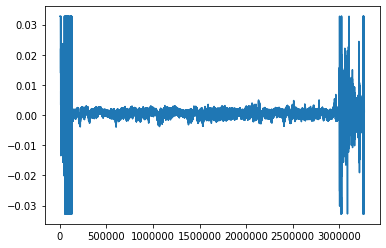

In [9]:
ecg["# ECG"].plot()

In [13]:
ECG_array = ecg["# ECG"].to_numpy() #save the data into an ndarray
ECG_array.size

3270000

In [127]:
ECG_array = raw_data[0] #Copy the data into an ndarray, which does the same thing with the former step
ECG_array.size

3270000

In [70]:
xf = np.linspace(-N*sampling_freq/2, N*sampling_freq/2,  N)
xf

array([-1635.   , -1634.999, -1634.998, ...,  1634.998,  1634.999,
        1635.   ])

#### Truncate the signal 
Get rid of the first 3mins and last 5mins

In [130]:
ECG_array = ECG_array[150000:-300000]  # Remove the signal in first 3minutes and last 5minutes

In [131]:
ECG_array.size

2820000

In [132]:
sampling_freq = 1/1000
N = ECG_array.size

In [133]:
index = np.linspace(0, round((N-1)*sampling_freq,4), N)
index

array([0.000000e+00, 1.000000e-03, 2.000000e-03, ..., 2.819997e+03,
       2.819998e+03, 2.819999e+03])

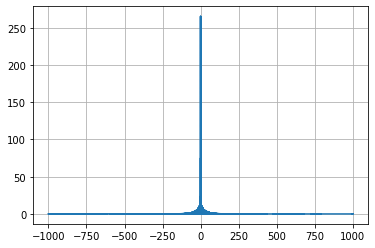

In [134]:
from scipy.fft import fft,fftshift
# Number of sample points

y = ECG_array
yf = fft(y)
yf = fftshift(yf)
xf = np.linspace(-1000, 1000, 2820000)
import matplotlib.pyplot as plt
plt.plot(xf, np.abs(yf))
#plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

#### Ideal filter

The result shows that the ideal filter will introduce some baseline drift, so we plan to use butterworth filter later

#### Butterworth Band pass Filter

In [83]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

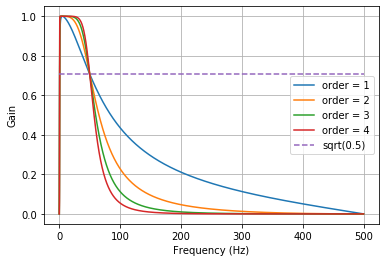

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 1000.0
lowcut = 0.5
highcut = 50.0

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [1, 2, 3, 4]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

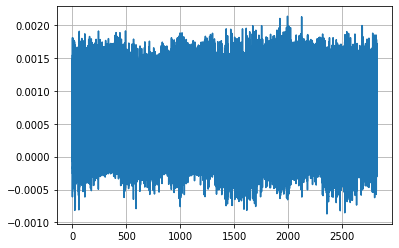

In [85]:
y = butter_bandpass_filter(ECG_array, lowcut, highcut, fs, order=2)
plt.plot(index, y, label='Filtered signal (Hz)')
plt.grid(True)
plt.show()

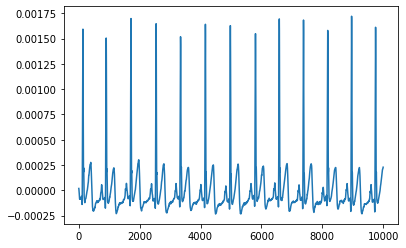

In [86]:
recover_ECG_example = y[370000:380000]
plt.plot(recover_ECG_example)

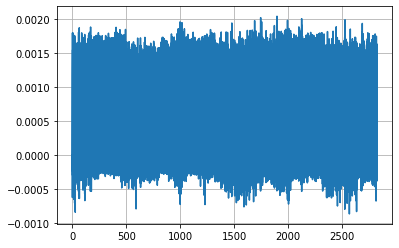

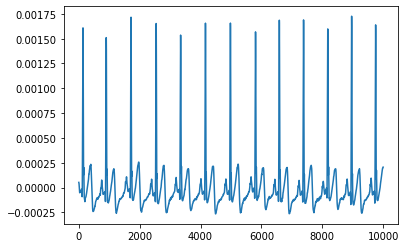

In [87]:
y = butter_bandpass_filter(ECG_array, lowcut, highcut, fs, order=3)
plt.plot(index, y, label='Filtered signal (Hz)')
plt.grid(True)
plt.show()
recover_ECG_example = y[370000:380000]
plt.plot(recover_ECG_example)
plt.show()

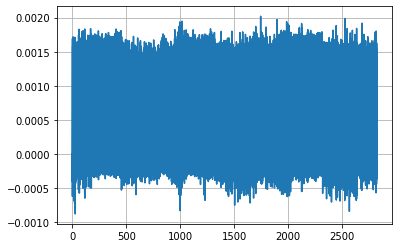

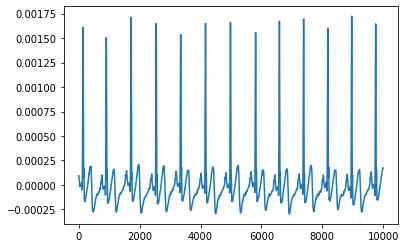

In [88]:
y = butter_bandpass_filter(ECG_array, lowcut, highcut, fs, order=4)
plt.plot(index, y, label='Filtered signal (Hz)')
#plt.xlabel('time (seconds)')
#plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
#plt.axis('tight')
#plt.legend(loc='upper left')
plt.show()
recover_ECG_example = y[370000:380000]
plt.plot(recover_ECG_example)
plt.show()

From the original signal, we could see that the T wave is much higher than P wave. Butterworth filter with order=2 could show this feature sucessfully. However, with order=3 and order=4, the difference between T wave and P wave are decreased.

#### Resampling
From 1000Hz to 200Hz, means resampling a signal from 2820000 points to 564001(751^2) points

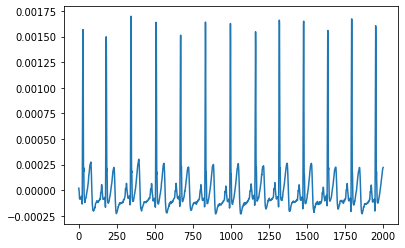

In [89]:
from scipy import signal
y = butter_bandpass_filter(ECG_array, lowcut, highcut, fs, order=2)
resampled_signal = signal.resample(y, 564001)
plt.plot(resampled_signal[74000:76000])
plt.show()

#### Amplitude Normalization

Is it a good idea to normalize the signal? Will normalization lose the features related with the signal amplitude?

In [137]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

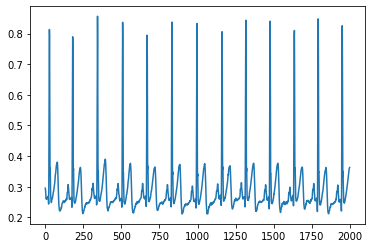

In [138]:
normalized_signal = NormalizeData(resampled_signal)
#norm1 = x / np.linalg.norm(x)
#norm2 = normalize(x[:,np.newaxis], axis=0).ravel()
plt.plot(normalized_signal[74000:76000])
plt.show()

#### SVD

In [94]:
from scipy import linalg
reshaped_signal = np.reshape(normalized_signal, (751,751))
U, s, Vh = linalg.svd(reshaped_signal)
print(reshaped_signal.shape)
print(U.shape)
print(s.shape)
print(Vh.shape)

(751, 751)
(751, 751)
(751,)
(751, 751)


#### Reconstruct the original matrix from the decomposition
For future decoding

In [95]:
m = 751
n = 751
sigma = np.zeros((m, n))
for i in range(min(m, n)):
    sigma[i, i] = s[i]
reconstructed_signal = np.dot(U, np.dot(sigma, Vh))
reshaped_recon_signal = np.reshape(reconstructed_signal, 564001)
np.allclose(reshaped_recon_signal, normalized_signal)
#True means the signal could be reconstructed back to the original one

True

#### Quantization

In [99]:
round_U = np.around(U,4) #Keep four decimals
print(round_U)
unique, counts = np.unique(round_U, return_counts=True)
U_dict = dict(zip(unique, counts))
unique.size

[[ 0.0106 -0.     -0.0411 ...  0.0511 -0.0162 -0.    ]
 [-0.0274  0.004   0.0647 ...  0.0607  0.0739  0.04  ]
 [-0.0038 -0.0233  0.0264 ... -0.0543 -0.0579 -0.0455]
 ...
 [ 0.0351 -0.0799 -0.0759 ... -0.0085  0.0252 -0.0086]
 [ 0.0456  0.0875 -0.0114 ... -0.0526  0.0041  0.037 ]
 [-0.0135  0.0119 -0.073  ... -0.0126 -0.008  -0.0299]]


2849

In [100]:
np.savetxt('U_round4.txt',round_U)

In [52]:
round_U = np.around(U,3) #Keep 3 decimals
#Lose a lot of information, which is not recommended here. There is no further discussion about this situation.
unique, counts = np.unique(round_U, return_counts=True)
U_dict = dict(zip(unique, counts))
unique.size

345

In [53]:
np.savetxt('U_round3.txt',round_U)

#### INSTRUCTION ON HOW TO COMPRESS THE DATA BY HUFFMAN CODING


(I used the package "tcmpr 0.2" and "pyhuff 1.1". These two packages provided the same compression result. So here, we just use "tcmpr 0.2")

1. Open your termial or git bash, enter "pip install tcmpr" to install the "tcmpr 0.2" package
2. Enter the directory which include the file you want to compress OR copy the path of the file you want to compress
3. Enter "tcmpr <filename>.txt" / "tcmpr <filepath>" to compress the file
4. Find the compressed file in the same directory of the original file



1. The file size(round 4) before Huffman coding is 14.4MB. The file size(round 4) after Huffman coding is 5.4MB
2. The file size(round 3) before Huffman coding is 14.4MB. The file size(round 3) after Huffman coding is 5.2MB


Also do this step for "s" and "Vh"

In [55]:
round_s = np.around(s,4)
unique, counts = np.unique(round_s, return_counts=True)
U_dict = dict(zip(unique, counts))
unique.size

347

In [56]:
np.savetxt('s_round4.txt',round_s)

"s" can be shrank from 19kb to 7kb

In [57]:
round_Vh = np.around(Vh,4)
#print(round_s)
unique, counts = np.unique(round_Vh, return_counts=True)
U_dict = dict(zip(unique, counts))
unique.size

2715

In [58]:
np.savetxt('Vh_round4.txt',round_Vh)

"Vh" can be shrank from 14.4MB to 5.4MB

In conclusion, the size of the original data in txt is 83.3MB. After compression, the size of the U, s, and Vh is 5.4MB, 7KB, and 5.4MB. The compression ratio is 7.7.
It seems that the compression result is not so ideal as we supposed. Also, the SVD decomposed the data into 3 matrices, but it actually expand the size/length of the data. So I was thinking.....

### What if I don't do SVD? Just compress the signal directly...

In [179]:
round_signal = np.around(normalized_signal,2) #round it with 2 decimals will be good
#Cuz keep only 1 decimal will lose a lot of information, and keep 3 decimals will be redundant 
#and the compression ratio will not be good.
print(round_signal)
unique, counts = np.unique(round_signal, return_counts=True)
U_dict = dict(zip(unique, counts))
unique.size

[0.26 0.18 0.09 ... 0.23 0.24 0.24]


99

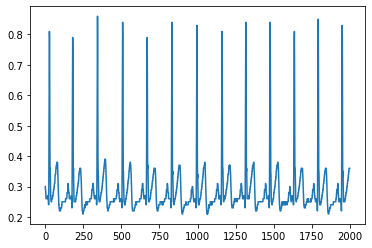

In [178]:
plt.plot(round_signal[74000:76000])
plt.show()

In [158]:
np.savetxt('signal_rounded.txt',round_signal)

In [159]:
decoded_data = np.loadtxt(fname = "signal_rounded.txt")

In [160]:
decoded_data

array([0.26, 0.18, 0.09, ..., 0.23, 0.24, 0.24])

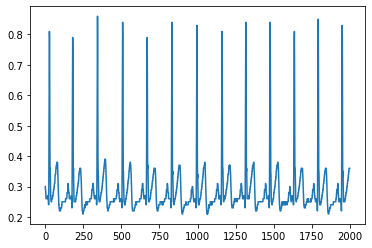

In [161]:
plt.plot(decoded_data[74000:76000])
plt.show()

In [162]:
np.allclose(decoded_data, normalized_signal)

False

In [164]:
np.allclose(decoded_data, round_signal)

True

In [156]:
decoded_data.size

564001

Use Huffman coding to encode this normalized signal sequence.

Before Huffman coding, the size of the txt file of this signal sequence is 14.1MB. After Huffman coding, the size of the txt file of this signal sequence is 4.9MB.

The original size of the raw data is 83.3MB. The compression ratio is 17


In [170]:
from sklearn.metrics import mean_squared_error
from math import sqrt
sqrt(sum((normalized_signal-decoded_data)**2)/(sum(normalized_signal**2)))

0.009485926127669679

#### PRD calculation:


In [174]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# original_signal = normalized_signal
# compressed_signal = decoded_data
def PRD_calculation(original_signal, compressed_signal):
    PRD = sqrt(sum((original_signal-compressed_signal)**2)/(sum(original_signal**2)))
    return PRD

PRD = PRD_calculation(normalized_signal, decoded_data)
print("The PRD is {}%".format(round(PRD*100,3)))

The PRD is 0.949%


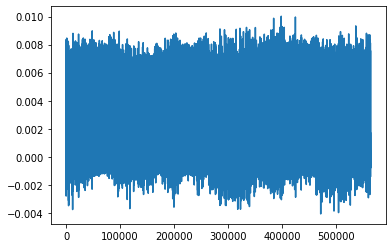

In [96]:
plt.plot(normalized_signal)

### Instructions

Put instructions of how to use your method here.

Dependencies:

### Evaluation

The results of this method on the following wearable sensors:

| Wearable Sensor | Compression Ratio | Percentage RMS difference |
| ------ | ------ | ------ | 
| ECG | XX | XX |
| PPG | XX | XX |
| ACC | XX | XX |
| EDA | XX | XX |
| TEMP | XX | XX |